<a href="https://colab.research.google.com/github/LaJeremi/Tensorflow-nlp-tutorial-Practice-/blob/main/21.%20Memory%20Network/%2021_02_memory_network_(kor).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 21-02 MemN으로 한국어 QA 해보기

출처: https://wikidocs.net/85470

# 1. 커스터마이즈드 KoNLPy 사용하기

# 2. 한국어 Babi 데이터셋 로드와 전처리


In [ ]:
import tensorflow as tf
tf.__version__
     

'2.9.2'

In [ ]:

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [ ]:

path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/'
                'babi_tasks_1-20_v1-2.tar.gz')
     

11745123/11745123 [==============================] - 0s 0us/step


In [ ]:
with tarfile.open(path) as tar:
 tar.extractall()
 tar.close()

DATA_DIR = 'tasks_1-20_v1-2/en-10k'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [ ]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
      break

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


In [ ]:

def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [ ]:

train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [ ]:

train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [ ]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [ ]:
train_stories[3576]


['John went back to the garden.',
 'Mary went to the kitchen.',
 'Sandra went back to the bedroom.',
 'John travelled to the bedroom.']

In [ ]:
train_questions[3576]


'Where is John? '

In [ ]:
train_answers[3576]


'bedroom'

In [ ]:
def tokenize(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x and x.strip()]

In [ ]:

def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [ ]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)


In [ ]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [ ]:
pip install customized_konlpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ckonlpy.tag import Twitter


In [ ]:

twitter = Twitter()
twitter.morphs('은경이는 사무실로 갔습니다.')
     

/usr/local/lib/python3.8/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은', '경이', '는', '사무실', '로', '갔습니다', '.']

In [ ]:

twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')

['은경이', '는', '사무실', '로', '갔습니다', '.']

In [ ]:

from ckonlpy.tag import Twitter
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

In [ ]:

TRAIN_FILE = os.path.join("/content/drive/MyDrive/Colab Notebooks/qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join("/content/drive/MyDrive/Colab Notebooks/qa1_single-supporting-fact_test_kor.txt")

# 새 섹션

In [ ]:

# TRAIN_FILE = os.path.join("qa1_single-supporting-fact_train_kor.txt")
# TEST_FILE = os.path.join("qa1_single-supporting-fact_test_kor.txt")

In [ ]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    i = i + 1
    print(line)
    if i == 20:
      break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [ ]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [ ]:

train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [ ]:

train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [ ]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))
     

훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [ ]:
train_stories[3572]


['은경이는 부엌으로 가버렸습니다.',
 '필웅이는 사무실로 가버렸습니다.',
 '수종이는 복도로 뛰어갔습니다.',
 '은경이는 사무실로 복귀했습니다.',
 '경임이는 사무실로 이동했습니다.',
 '경임이는 침실로 갔습니다.']

In [ ]:
train_questions[3572]


'은경이는 어디야? '

In [ ]:
train_answers[3572]


'사무실'

In [ ]:

def tokenize(sent):
  return [ x.strip() for x in re.split('(\W+)', sent) if x and x.strip()]

In [ ]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [ ]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)


In [ ]:
print(word2idx)


{'.': 1, '경임이는': 2, '은경이는': 3, '수종이는': 4, '필웅이는': 5, '이동했습니다': 6, '가버렸습니다': 7, '뛰어갔습니다': 8, '복귀했습니다': 9, '갔습니다': 10, '화장실로': 11, '정원으로': 12, '복도로': 13, '어디야': 14, '?': 15, '부엌으로': 16, '사무실로': 17, '침실로': 18, '화장실': 19, '정원': 20, '사무실': 21, '침실': 22, '복도': 23, '부엌': 24}


In [ ]:
vocab_size = len(word2idx) + 1


In [ ]:

print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 40
질문의 최대 길이 : 3


In [ ]:

def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

        # 스토리와 질문은 각각의 최대 길이로 패딩
        # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [ ]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [ ]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)


(10000, 40) (10000, 3) (10000, 25) (1000, 40) (1000, 3) (1000, 25)


# 3. 메모리 네트워크로 QA 태스크 풀기


In [ ]:
Xstrain[3576]


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  3, 12,  9,  1,  5, 16,  6,  1,  2, 18,
        9,  1,  3, 18,  7,  1], dtype=int32)

In [ ]:
Xqtrain[3576]


array([ 3, 14, 15], dtype=int32)

In [ ]:
Ytrain[3576]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [ ]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [ ]:

# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [ ]:

# 플레이스 홀더. 입력을 담는 변수
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:

# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원

# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [ ]:

# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [ ]:

# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 40, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 40, 3), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 3, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")


In [ ]:

# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 40, 3), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [ ]:
# 유사도가 반영된 어텐션 분포 행렬과 임베딩 C를 거친 스토리 행렬을 더한다.
# 두 행렬 모두 크기는 (68, 4)이다.
# 이로부터 얻은 행렬은 어텐션 값 행렬(Attention Value Matrix)이다.
response = add([match, input_encoded_c])

In [ ]:
# 질문 행렬은 (4, 50)의 크기를 가진다.
# 하지만 어텐션 값 행렬의 크기는 (68, 4)이다.
# 이 두 개를 연결시켜주기 위해서 어텐션 값 행렬의 크기를 (4, 68)로 변환해준다.
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)

# 질문 행렬과 어텐션 값 행렬을 연결한다.
# (4, 118)의 크기를 가진다.
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
     

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 3, 40), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")
Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 3, 90), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [ ]:

answer = LSTM(lstm_size)(answer)
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)

In [ ]:

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

# start training the model
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))

# save model
model.save('model.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 50)     1250        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 3, 50)        1250        ['input_2[0][0]']                
                                                                                              

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))


32/32 [==============================] - 0s 5ms/step - loss: 0.2049 - acc: 0.9460

 테스트 정확도: 0.9460


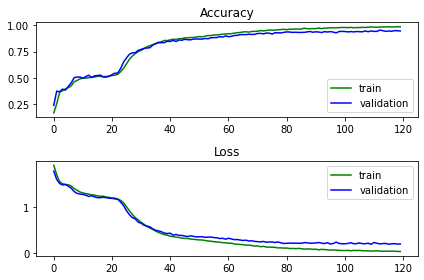

32/32 [==============================] - 1s 3ms/step


In [ ]:

# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)